In [3]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2

In [4]:
def draw_multiline_text(text, size=(800, 600), font_size=40, font='arial', show=False):

    def fit_horizontal():
        return upper_x > offset_x and lower_x < size[0] - offset_x

    def fit_vertical():
        return upper_y > offset_y and lower_y < size[1] - offset_y

    offset_x = size[0] // 7
    offset_y = size[1] // 7
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)

    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
    if not fit_horizontal():
        return draw_multiline_text(text, size = (size[0] + 100, size[1]),
                                   font_size=font_size, font=font, show=show)
    if not fit_vertical():
        return draw_multiline_text(text, size = (size[0], size[1] + 100),
                                   font_size=font_size, font=font, show=show)

    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

In [5]:
def remove_black_padding(img):
    matrix = np.array(img)
    matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char == 'j':
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

In [6]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

In [7]:
char_a = draw_single_character('j', 99, font='open-sans')
display(char_a)

In [106]:
characters = string.ascii_uppercase + string.ascii_lowercase + string.digits + ",.?!"

In [109]:

txt = '''
The quick brown fox jumped over the back of a lazy dog.?
                 012345,6789!
'''

# txt = txt.lower()
txt = "".join(list(map(lambda x: x if x in characters or x == '\n' else " ", txt)))

out, f_size = draw_multiline_text(txt, size= (600, 400), font='open-sans', font_size=25)

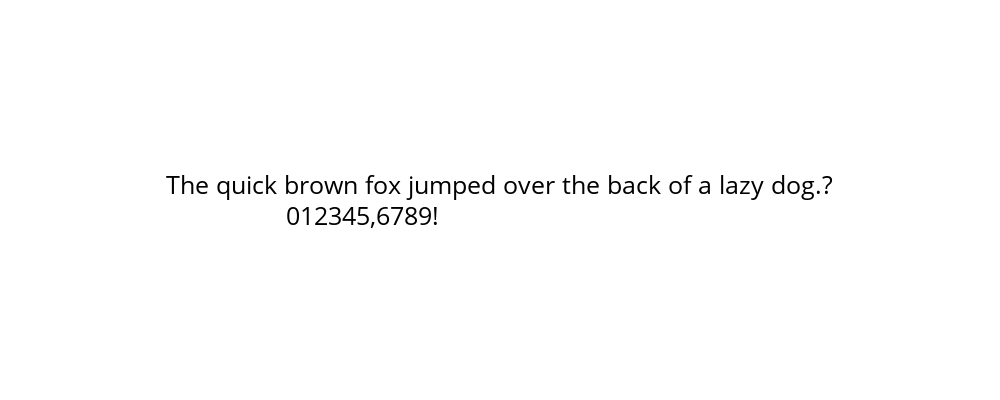

In [110]:
display(out)

In [111]:
def get_all_character(font, fontsize):
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))

In [112]:
def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img, dtype=float)

def matrix_to_image(matrix):
    return Image.fromarray(matrix).convert('L')

def invert_colors(matrix):
    return 255 - matrix

def convolve_images(pattern, image):
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))

def normalize(matrix):
    return 255 * (matrix / np.max(matrix))

def threshold_matrix(matrix, k=150):
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


In [113]:
def reduce_noise(img, k = 80):
    matrix = img_to_matrix(img)
    u, s, v = np.linalg.svd(matrix)
    mat = u[:, :k] @ np.diag(s[:k]) @ v[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')


In [114]:
def count_lines(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    return matrix.shape[0] - np.count_nonzero(matrix) - np.argmax(matrix) - np.argmax(matrix[::-1])

def count_something(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    best_angle = 0
    best_score = 0
    for i in range(180):
        rotated = rotate_image(img, i)
        if (score := count_lines(rotated)) > best_score:
            best_score = score
            best_angle = i

    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


In [117]:
from bisect import bisect_left
from intervaltree import IntervalTree, Interval
import networkx as nx


def prepare_images(images):
    return list(
        map(lambda x: threshold_matrix(x, 220),
        map(invert_colors,
        map(img_to_matrix, images)))
    )

def split_lines(matrix):
    matrix = threshold_matrix(matrix)
    matrix = np.sum(matrix, axis=1)
    matrix[matrix > 0] = 1
    lines = [np.argmax(matrix) - 1]
    i = lines[-1] + 1
    while i < matrix.shape[0]:
        if matrix[i] == 0:
            lines.append(i)
            while i < matrix.shape[0] and matrix[i] == 0:
                i += 1
        i += 1
    return lines[:-1]

def remove_empty(lines, font_size):
    min_height = font_size // 3
    new_lines = [lines[0]]
    for x in lines[1:]:
        if x - new_lines[-1] > min_height:
            new_lines.append(x)
    for i in range(len(new_lines)):
        new_lines[i] += min_height // 3
    return new_lines

def find_occurrences(pattern, image, eps=0.1):
    convolution = convolve_images(pattern, image)
    max_correlation = np.sum(pattern * pattern)
    return list(zip(*np.where(np.abs(convolution - max_correlation) < eps * max_correlation)))

def create_graph(font, font_size, chars):
    images = [draw_multiline_text(c, size=(font_size*2, font_size*2), font=font, font_size=font_size)[0] for c in characters]
    images = prepare_images(images)

    g = [[] for _ in range(len(chars))]
    for i, pattern in enumerate(chars):
        for j, image in enumerate(images):
            if i != j and find_occurrences(pattern, image):
                g[j].append(i)
    return g

def dfs(v, g, visit, order):
    visit[v] = True
    for s in g[v]:
        if not visit[s]:
            dfs(s, g, visit, order)
    order.append(v)

def topological_sort(g):
    n = len(g)
    visit = np.full(n, False)
    order = []
    for i in range(n):
        if not visit[i]:
            dfs(i, g, visit, order)
    return np.array(order)[::-1]


def pagerank_order(g):
    n = len(g)
    graph = nx.DiGraph()
    graph.add_nodes_from(range(len(g)))
    graph.add_edges_from([(i, j) for i in range(n) for j in g[i]])
    rank = nx.pagerank(graph).values()
    return np.argsort(np.array(list(rank)))

def power_method(g):
    n = len(g)
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i, g[i]] = 1

    x = np.full(n, 1 / n, float)
    for _ in range(100):
        x = x @ matrix
    return np.argsort(x)

def ocr(image, font, font_size, order=None, rotate=False):
    if rotate:
        image = correct_angle(image)

    chars = get_all_character(font, font_size)
    char_arrays = prepare_images(chars)
    matrix = prepare_images([image])[0]

    if order is None:
        g = create_graph(font, font_size, char_arrays)
        order = pagerank_order(g)

    lines = remove_empty(split_lines(matrix), font_size)
    n = len(lines)
    intervals = [IntervalTree() for _ in range(n)]
    line_maps = [{} for _ in range(n)]

    for c in order:
        for i, j in find_occurrences(char_arrays[c], matrix):
            inter = bisect_left(lines, i) - 1
            left, right = j - char_arrays[c].shape[1] + 2, j - 2
            if left >= right:
                left, right = j - 2, j - 1
            new_inter = Interval(left, right)
            if intervals[inter].overlaps(new_inter):
                continue
            intervals[inter].add(new_inter)
            line_maps[inter][(left, right)] = characters[c]

    space = img_to_matrix(draw_single_character(' ', font_size, font)).shape[1]
    sorted_lines = [sorted(line.items()) for line in line_maps]
    sorted_lines = list(filter(len, sorted_lines))

    leftmost = min(line[0][0][0] for line in sorted_lines)
    output = ""
    for line in sorted_lines:
        last_x = leftmost
        for (left, right), char in line:
            if left - last_x >= space:
                output += " "*((left - last_x) // space)
            output += char
            last_x = right
        output += '\n'

    return output

In [118]:
result = ocr(out, 'open-sans', f_size)

In [119]:
print(result)

The quick brown fox jumped over the back of a lazy dog.?
                 012345,6789!



In [120]:
import Levenshtein
print(1 - Levenshtein.distance(result, txt) / max(len(result), len(txt)))

0.9886363636363636
